In [1]:
import os
import sys
import pandas
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split,KFold, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_absolute_error
sys.path.insert(0,'/Users/jacobv/git/data_driven_pathology/')
import CrossDecomp as xd

/Users/jacobv/jakepy/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Get data

In [3]:
# from scipy.io import loadmat
# bd = loadmat(filepath)
# filepath = '/Users/jacobv/Science/PLS_GXP/Mouse/brainDivision.mat'
# bd['brainDivision'][0][0][0][0][0][0].shape

In [3]:
import mat73
data_dict = mat73.loadmat('/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_E13pt5.mat')
arrays = {}
for k, v in data_dict.items():
    try:
        arrays[k] = np.array(v)
    except:
        arrays[k] = str(v)

ERROR:root:ERROR: MATLAB type not supported: table, (uint32)
ERROR:root:ERROR: MATLAB type not supported: table, (uint32)


In [20]:
# filepath = '/Users/jacobv/Science/PLS_GXP/Mouse/voxelGeneExpression_E11pt5.mat'
# arrays = {}
# f = h5py.File(filepath,mode='r')
# for k, v in f.items():
#     arrays[k] = np.array(v)

In [4]:
arrays.keys()

dict_keys(['coOrds', 'geneIDs', 'geneInfo', 'voxGeneMat', 'voxLabelTable'])

array([[3707764736,          2,          1,          1,          7,
                 7]], dtype=uint32)

In [5]:
coords = pandas.DataFrame(arrays['coOrds'])
print(coords.shape)
#print(arrays['geneIDs'].shape)
exp = pandas.DataFrame(arrays['voxGeneMat'])
print(exp.shape)
gdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/AMBAGeneInfo.csv')
print(gdf.shape)
vdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/AMBAvoxLabelTable.csv')
print(vdf.shape)

(9510, 3)
(9510, 2096)
(2015, 7)
(24213, 11)


In [6]:
# Match exp to gdf
eids = arrays['geneIDs'].astype(int)
missing = list(set(eids) - set(gdf.entrezID.values))
print(len(missing),'missing from gdf')
gdf.loc[:,'orig_index'] = gdf.index.values
gdf.index = gdf.entrezID.values
gdf = gdf.reindex(eids)
gdf.entrezID = gdf.index
gdf.index = range(len(gdf))

TypeError: 'numpy.int64' object is not iterable

In [248]:
# fill in missing genes
hlog = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HomoloGene ID	Common Organism Name	NCBI Taxon ID	S',
                      sep='\t')
hmouse = hlog[hlog['Common Organism Name']=='mouse, laboratory']

In [249]:
missing_stack = hmouse[hmouse['EntrezGene ID'].isin(missing)]
for m in missing:
    if m not in missing_stack['EntrezGene ID'].values: 
        print('couldnt find',m)
    else:
        gdf.loc[gdf.entrezID==m,'acronym'
               ] = missing_stack.loc[missing_stack['EntrezGene ID']==m,
                                    'Symbol']

couldnt find 627415


#### clean up exp dataframe

In [26]:
todrop = []
for col in exp.columns:
    if not any(pandas.notnull(exp[col].values)):
        todrop.append(col)

In [27]:
exp.drop(todrop,axis=1,inplace=True)
exp.shape

(2100, 10834)

In [28]:
res = pandas.DataFrame(index=exp.index)
for i,row in exp.iterrows():
    n = len([x for x in row.values if pandas.notnull(x)])
    res.loc[i,'n'] = n
res.loc[:,'p'] = res.n.values / exp.shape[1]

In [29]:
sns.displot(res.p)

original


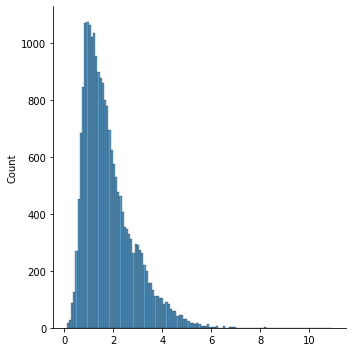

log


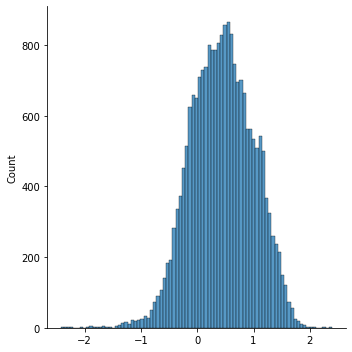

original


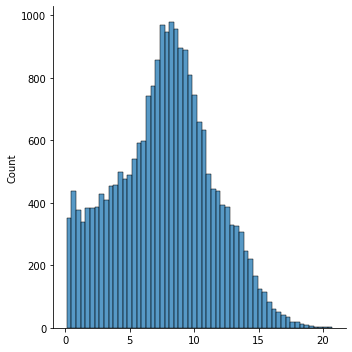

log


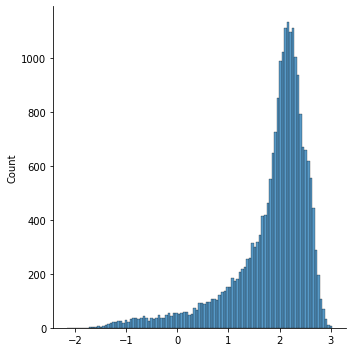

original


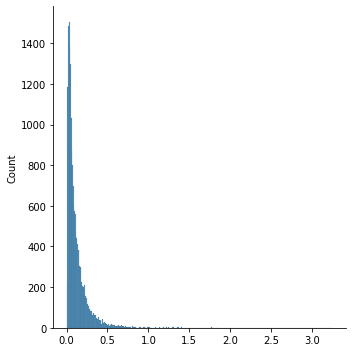

log


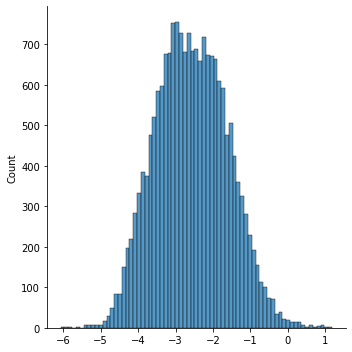

original


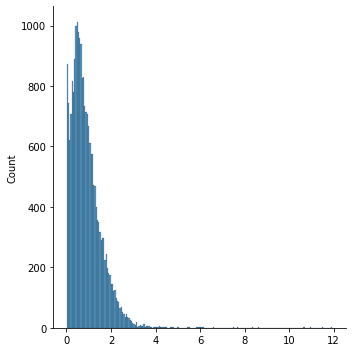

log


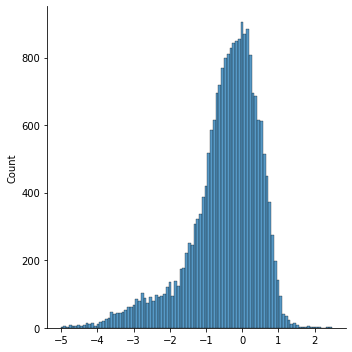

original


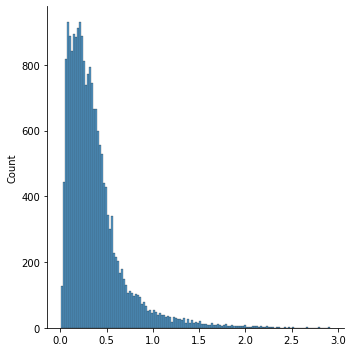

log


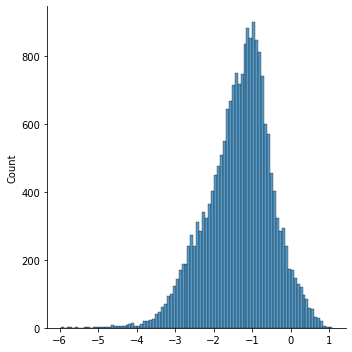

original


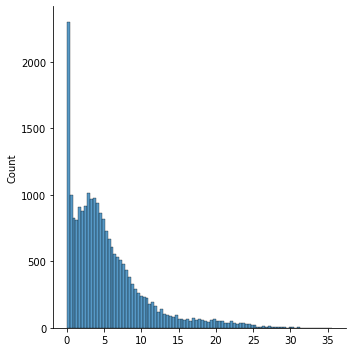

log


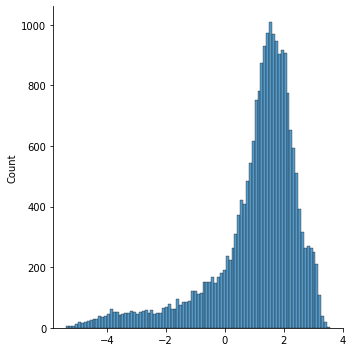

original


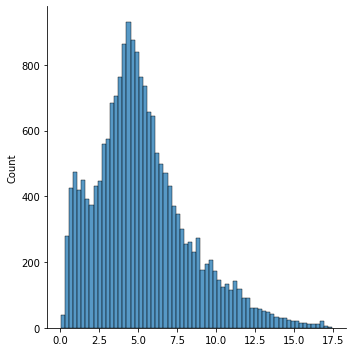

log


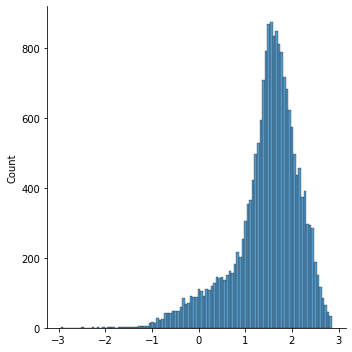

original


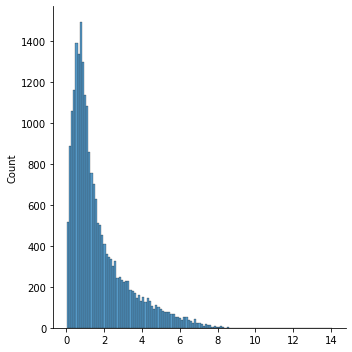

log


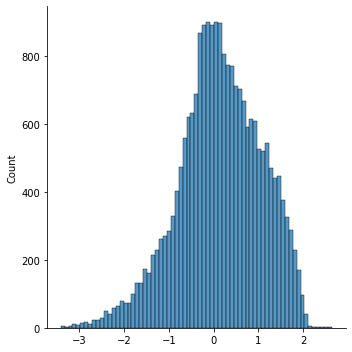

original


log


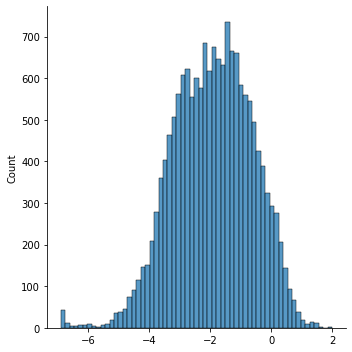

original


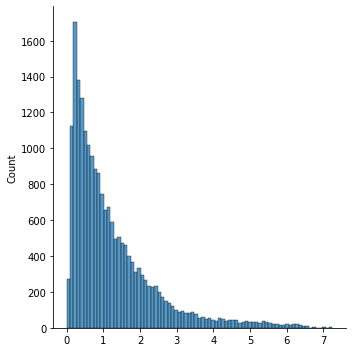

log


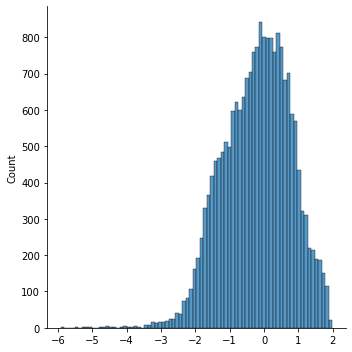

In [15]:
for i in range(10):
    print('original')
    sns.displot(exp.loc[i].dropna().values)
    plt.show()
    print('log')
    sns.displot(np.log(exp.loc[i].dropna().values+0.001))
    plt.show()

#### Do some imputation

In [34]:
### Considerations: Do i Log transform everything?
### How long is this stuff going to take?
imputed = {}

In [35]:
%%time
# simple imputer
imputed.update({'SI':SimpleImputer(strategy='median'
                                  ).fit_transform(exp.values)})


CPU times: user 2.98 s, sys: 411 ms, total: 3.39 s
Wall time: 3.39 s


In [36]:
%%time
# knn
imputed.update({'KNN':KNNImputer().fit_transform(exp.values)})

CPU times: user 5min 56s, sys: 9.34 s, total: 6min 5s
Wall time: 6min 7s


In [37]:
#pandas.to_pickle(imputed,'/Users/jacobv/Science/PLS_GXP/Mouse/imputed_gxp_E11pt5.pk')

In [ ]:
%%time
# iterative imputer
imputed.update({'II':IterativeImputer().fit_transform(exp.values)})

In [33]:
#imputed = pandas.read_pickle('/Users/jacobv/Science/PLS_GXP/Mouse/imputed_gxp_E11pt5.pk')

In [38]:
iexp = pandas.DataFrame(imputed['KNN'],
                        index=exp.index,columns=exp.columns)

In [39]:
coords = coords.T.loc[iexp.columns]

In [40]:
coords.columns = ['y','z','x']

In [41]:
coords.head()

y     z    x
0  53.0  26.0  6.0
1  54.0  26.0  6.0
2  55.0  26.0  6.0
3  56.0  26.0  6.0
4  57.0  26.0  6.0

# Quick mouse PLS

In [21]:
#from sklearn.decomposition import PCA

In [42]:
pcamod = PCA(n_components=100, random_state=123).fit(iexp.T)
sum(pcamod.explained_variance_ratio_)

0.8982279992365039

(0.0, 10.0)

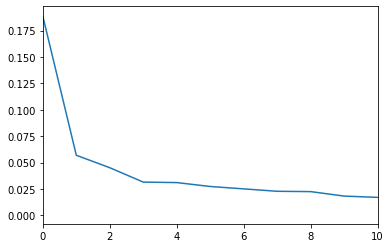

In [43]:
plt.plot(pcamod.explained_variance_ratio_)
plt.xlim(0,10)

In [45]:
pcamod.explained_variance_ratio_.round(3)

array([0.416, 0.083, 0.046, 0.034, 0.03 , 0.026, 0.021, 0.017, 0.015,
       0.015, 0.012, 0.011, 0.01 , 0.008, 0.008, 0.007, 0.006, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001])

In [25]:
pca_tfm.shape

(24044, 100)

In [44]:
pca_tfm = pandas.DataFrame(pcamod.transform(iexp.T),
                          index=iexp.columns)


In [45]:
vdf = vdf.loc[iexp.columns]

In [46]:
brainpart = ['Forebrain' if vdf.loc[x,'isForebrain']==1 else\
             'Midbrain' if vdf.loc[x,'isMidbrain']==1 else\
             'Hindbrain' if vdf.loc[x,'isHindbrain']==1 else\
             'Other' for x in vdf.index]
vdf.loc[:,'BrainPart'] = brainpart

In [47]:
vdf.BrainPart.value_counts()

Forebrain    8890
Hindbrain    1826
Midbrain      118
Name: BrainPart, dtype: int64

In [48]:
pca_tfm.shape

(10834, 100)

In [49]:
jnk = pandas.DataFrame(pca_tfm,copy=True)
jnk.loc[:,'BrainPart'] = vdf.BrainPart.values

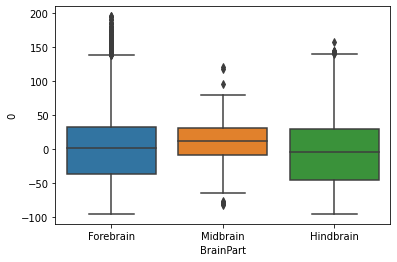

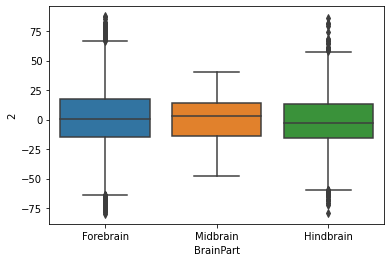

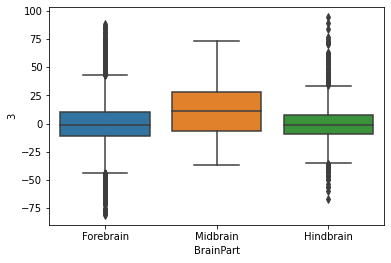

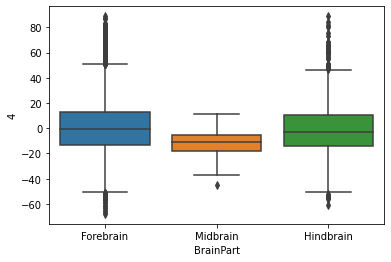

In [50]:
for i in range(5):
    sns.boxplot(x='BrainPart',y=pca_tfm.columns[i],data=jnk,
                order=['Forebrain','Midbrain','Hindbrain'])
    plt.show()

In [51]:
del(jnk)

In [52]:
tr,te = train_test_split(pca_tfm, stratify=vdf.BrainPart.values, 
                         random_state=123)
tr_y = coords.loc[tr.index]
te_y = coords.loc[te.index]

In [53]:
from sklearn.model_selection import KFold

ncs = 3
nc_chooser = pandas.DataFrame(index = range(ncs*1), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), }
#    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        for it in range(10):
            cv=KFold(n_splits=10,shuffle=True,random_state=123+it)
            pred = cross_val_predict(estimator, tr, tr_y, 
                                    groups = vdf.loc[tr.index].BrainPart.values, 
                                     cv=cv)
            nc_chooser.loc[i, 'r2'] = r2_score(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=tr_y, y_pred=pred)
            nc_chooser.loc[i, 'estimator'] = lab
            nc_chooser.loc[i,'nc'] = nc
            nc_chooser.loc[i,'iter'] = it
            i+=1

1
2
3


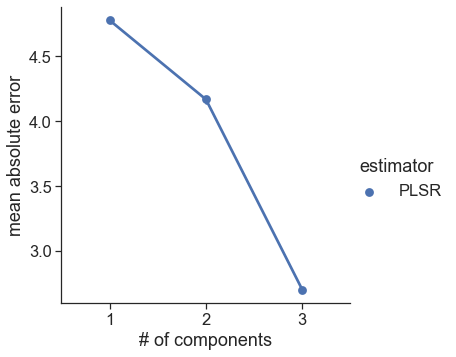

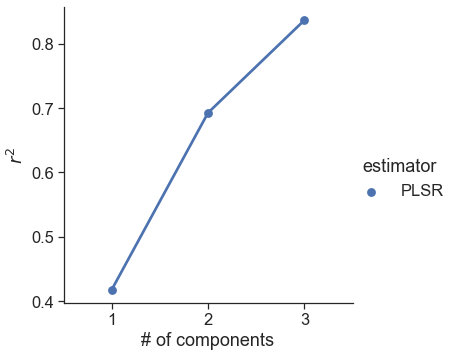

In [54]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

sns.catplot(x = 'nc', y='mae', hue = 'estimator', 
               data=nc_chooser,aspect=1,kind='point')
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_mae_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

sns.catplot(x = 'nc', y='r2', hue = 'estimator', 
               data=nc_chooser[nc_chooser.nc<5],
               aspect=1,kind='point')
plt.ylabel('$r^{2}$')
plt.xlabel('# of components')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/estimator_selection_cv_r2_rkf.pdf', 
#             bbox_inches='tight')
plt.show()

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


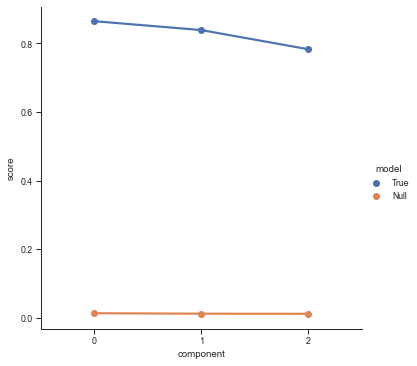

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***


In [55]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)
results, comp_sig = xd.evaluate_components(pls_mod, tr, tr_y, n_iterations=1000)

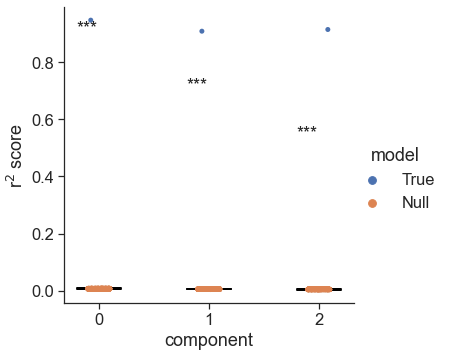

In [46]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
sns.catplot(x='component', y='score', hue='model', data=results)
plt.text(-0.20,0.9,'***')
plt.text(0.80,0.7,'***')
plt.text(1.80,0.53,'***')
plt.ylabel('r$^2$ score')
for c in range(len(results.component.unique())):
    cvals = results[(results.model=='Null')&(results.component==c)
                ].score.sort_values().values
    cmin = cvals[25]
    cmax = cvals[975]
    plt.plot([c-.2,c+.2],[cmin,cmin],lw=2,c='black')
    plt.plot([c-.2,c+.2],[cmax,cmax],lw=2,c='black')
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/sig_componentsTR.pdf',
#              bbox_inches='tight')

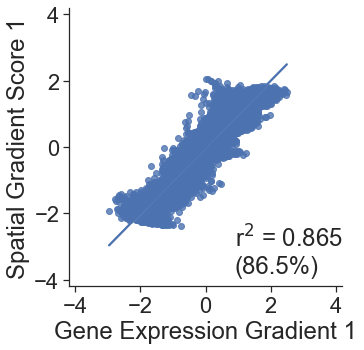

r2 = 0.8650043708141572, percent of total = 0.8650043708141572


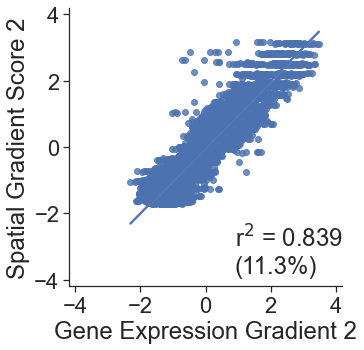

r2 = 0.839135260302209, percent of total = 0.11327959243652272


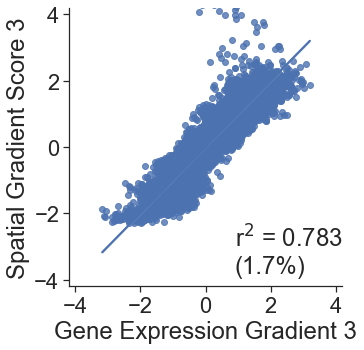

r2 = 0.7832462843797089, percent of total = 0.0170090050953582


In [56]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(tr,tr_y)

# plot component scores
sns.set_context('notebook',font_scale=2)
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = (leftover * r2)
    exp_perc = explained * 100
    plt.close()
    plotr = pandas.concat([pandas.Series(pls_mod.x_scores_[:,i]),
                          pandas.Series(pls_mod.y_scores_[:,i])],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr)
    plt.xlim(-4.2,4.2)
    plt.ylim(-4.2,4.2)
    g.set(xticks=[-4,-2,0,2,4])
    plt.xlabel('Gene Expression Gradient %i'%(i+1))
    plt.ylabel('Spatial Gradient Score %i'%(i+1))
    plt.text(.9,-3.8,'r$^2$ = %s \n(%s%%)'%(round(r2,3),round(exp_perc,1)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/principal_correlation_%s.pdf'%i,
#                bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover -= explained


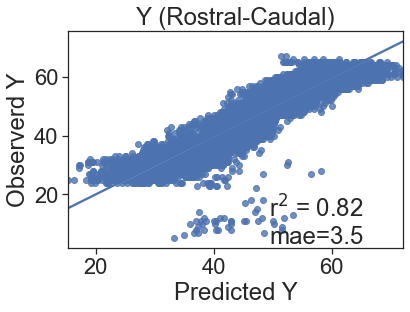

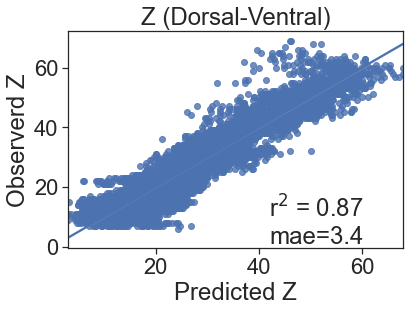

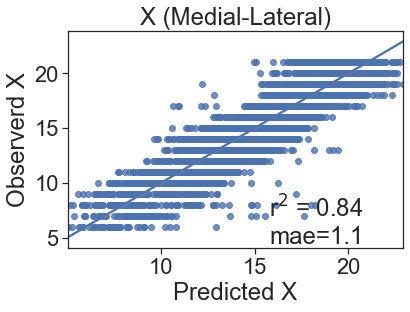

In [57]:
# plot model fit
pred = pls_mod.predict(tr)
labs = dict(zip(['Y','Z','X'],
                ['Rostral-Caudal',
                  'Dorsal-Ventral',
                  'Medial-Lateral']))

for i in range(tr_y.shape[-1]):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    label = tr_y.columns[i][-1].upper()
    sns.regplot(x=pred[:,i], y=tr_y[tr_y.columns[i]],
                #color = colos[label]
               )
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    
#     tx = np.max(pred[:,i]) - np.min(pred[:,i]) * .4
#     tx = np.min(pred[:,i]) + tx
#     ty = np.max(tr_y[tr_y.columns[i]]
#                ) -np.min(tr_y[tr_y.columns[i]]) * -.5
#     ty = np.min(tr_y[tr_y.columns[i]]) + ty
    r2 = stats.pearsonr(pred[:,i], tr_y[tr_y.columns[i]])[0]**2
    mae = mean_absolute_error(pred[:,i], tr_y[tr_y.columns[i]])
    plt.text(0.6,0.02,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes)
#     plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/HBM/Figs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


In [105]:
preds_df.shape

(18033, 7)

In [57]:
set(preds_df.index) - set(vdf.index)

set()

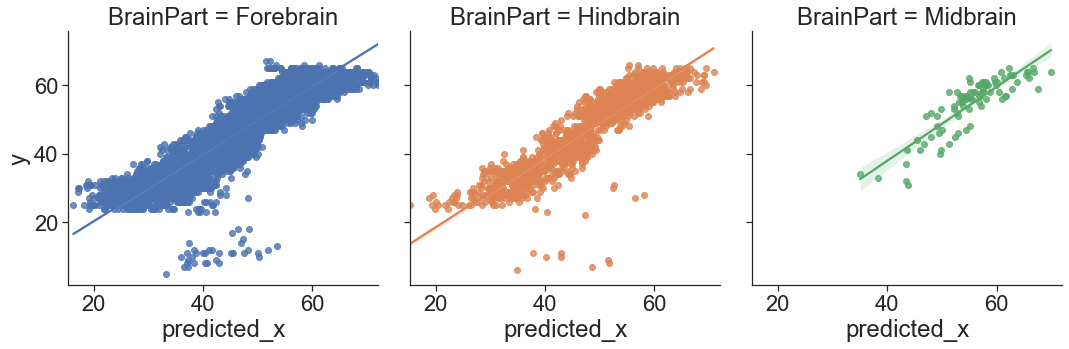

Forebrain r2 =0.8231180631650145
Forebrain mae =3.4458621998961028
Hindbrain r2 =0.7974156295095097
Hindbrain mae =3.632112025572774
Midbrain r2 =0.7536377696628359
Midbrain mae =3.2237412942057704


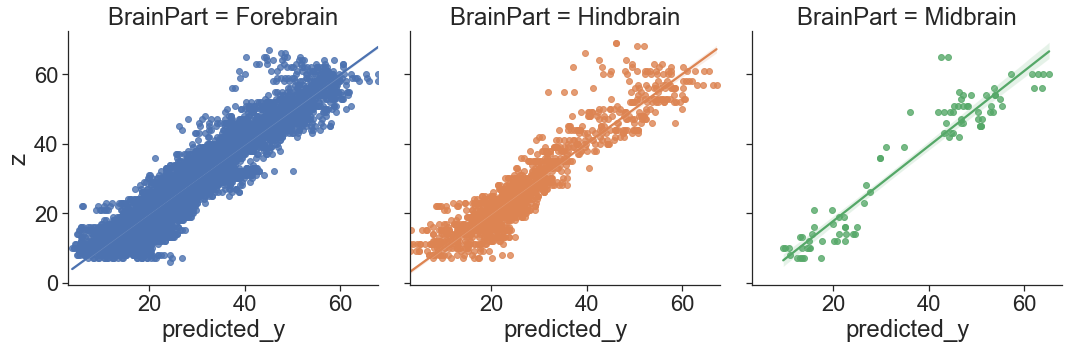

Forebrain r2 =0.8687408279175263
Forebrain mae =3.409712136885987
Hindbrain r2 =0.8690206319127193
Hindbrain mae =3.4765605133709134
Midbrain r2 =0.903204919241033
Midbrain mae =4.7418944996183825


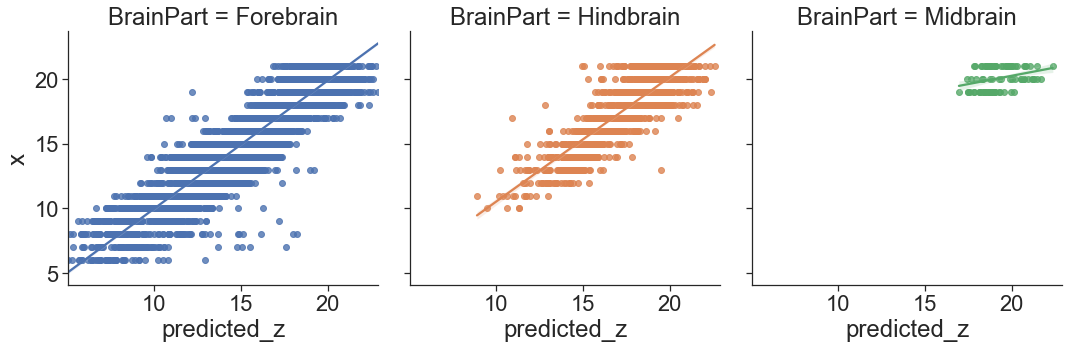

Forebrain r2 =0.8397990534972604
Forebrain mae =1.0881341977964427
Hindbrain r2 =0.7195420151956587
Hindbrain mae =1.080368565845353
Midbrain r2 =0.11610446473065766
Midbrain mae =1.1613240485210334


In [58]:
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=tr_y.index), tr_y],axis=1)
preds_df.columns = ['predicted_x', 'predicted_y','predicted_z'] + tr_y.columns.tolist()
preds_df.loc[:,'BrainPart'] = vdf.loc[preds_df.index].BrainPart.values
n_components = tr_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'BrainPart', data = preds_df,hue='BrainPart')
    #plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.BrainPart.unique():
        if not pandas.notnull(slab):
            continue
        r2 = stats.pearsonr(preds_df[preds_df.BrainPart==slab][preds_df.columns[i]],
                           preds_df[preds_df.BrainPart==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.BrainPart==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.BrainPart==slab
                                          ][preds_df.columns[i+n_components]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [59]:
jnk = pandas.DataFrame(coords,copy=True)
jnk.loc[:,'BrainPart'] = vdf.BrainPart.values

In [61]:
jnk.loc[:,'inv_z'] = jnk.z.max() - jnk.z.values

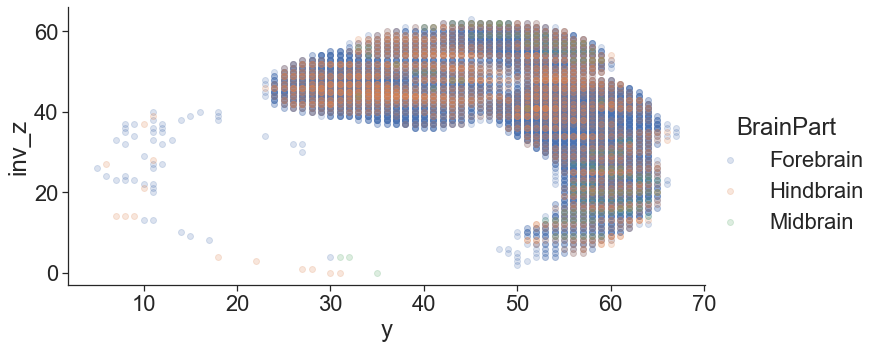

In [63]:
sns.lmplot(x='y',y='inv_z',data=jnk,fit_reg=False,hue='BrainPart',aspect=2,
          scatter_kws={'alpha':0.2}#{'s':5}
          )

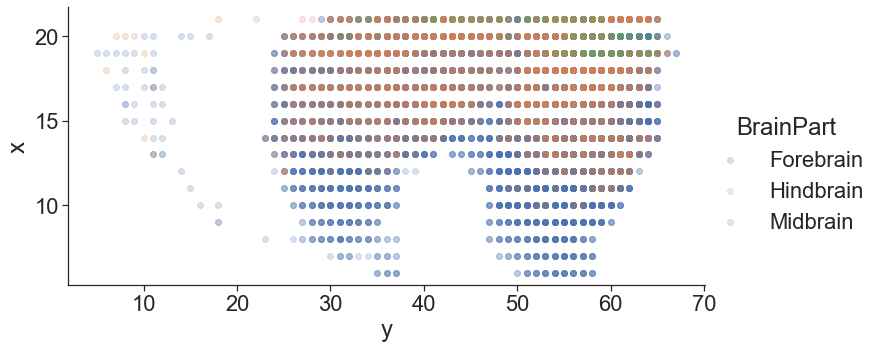

In [65]:
sns.lmplot(x='y',y='x',data=jnk,fit_reg=False,hue='BrainPart',aspect=2,
          scatter_kws={'alpha':0.2}#{'s':5}
          )

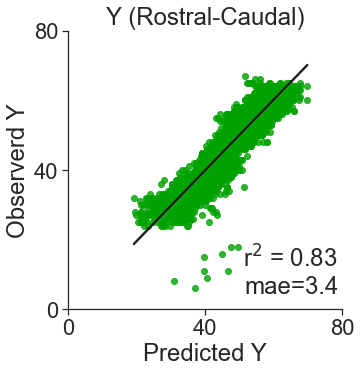

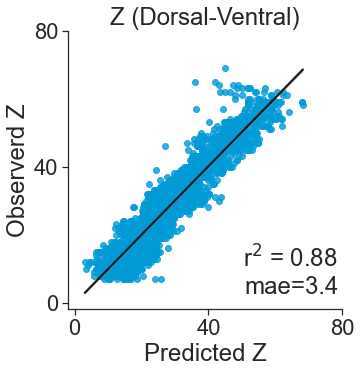

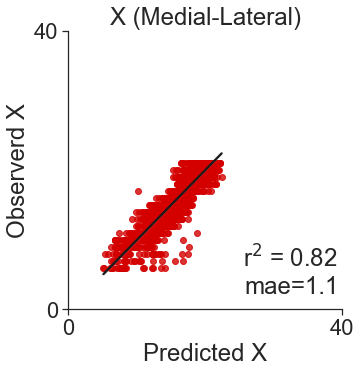

In [66]:
pal=sns.color_palette('nipy_spectral',n_colors=12)
colos = dict(zip(['Y','Z','X'],
                [pal[5],pal[3],pal[-1]]
                ))
# pal

# plot model fit
dims = ['Y','Z','X']
labs = dict(zip(dims,['Rostral-Caudal',
                      'Dorsal-Ventral',
                      'Medial-Lateral']))
te_pred = pls_mod.predict(te)
for i in range(te_y.shape[-1]):
#     fig = plt.figure(figsize=(6,4))
#     ax = fig.add_subplot(111)
    label = te_y.columns[i][-1].upper()
    plotr = pandas.concat([pandas.Series(te_pred[:,i]),
                          pandas.Series(te_y[te_y.columns[i]].values)],
                         axis=1)
    plotr.columns = ['x','y']
    g=sns.lmplot(x='x', y='y',data=plotr,
                 scatter_kws={'color':colos[label]},
                 line_kws={'color':'k'}
                )
    pmax = np.max(plotr.max().values)
    pmin = np.min(plotr.min().values)
    incr = 40
    tmin = int(round((pmin/incr))*incr)
    tmax = int(round((pmax/incr))*incr) + 1
    trange = list(range(tmin,tmax,incr))
    plt.title('%s (%s)'%(label,labs[label]))
    plt.xlabel('Predicted %s'%label)
    plt.ylabel('Observerd %s'%label)
    plt.xlim(pmin-5,pmax+5)
    plt.ylim(pmin-5,pmax+5)
    g.set(xticks=trange,yticks=trange)
    r2 = stats.pearsonr(te_pred[:,i], te_y[te_y.columns[i]])[0]**2
    mae = mean_absolute_error(te_pred[:,i], te_y[te_y.columns[i]])
    plt.text(0.85,0.2,
             'r$^2$ = %s \nmae=%s'%(round(r2,2),round(mae,1)),
            transform=ax.transAxes,horizontalalignment='right')
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/TestRes_%s.pdf'%label,
#                bbox_inches='tight')
    plt.show()


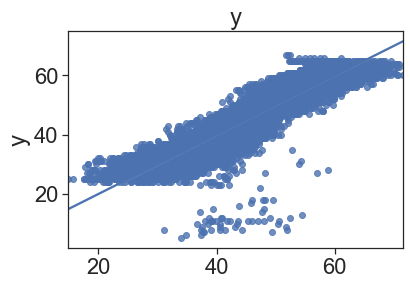

(0.9082535056239448, 0.0)
3.397180651725461


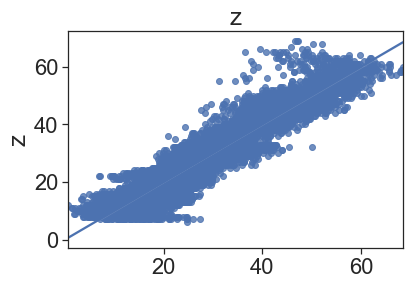

(0.9350639692326893, 0.0)
3.388191244630469


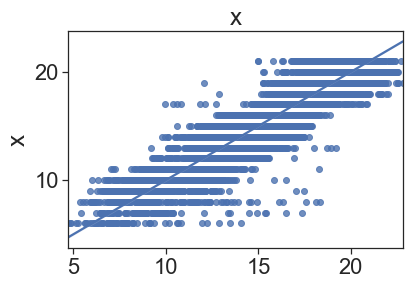

(0.9137752266148215, 0.0)
1.082130008753299


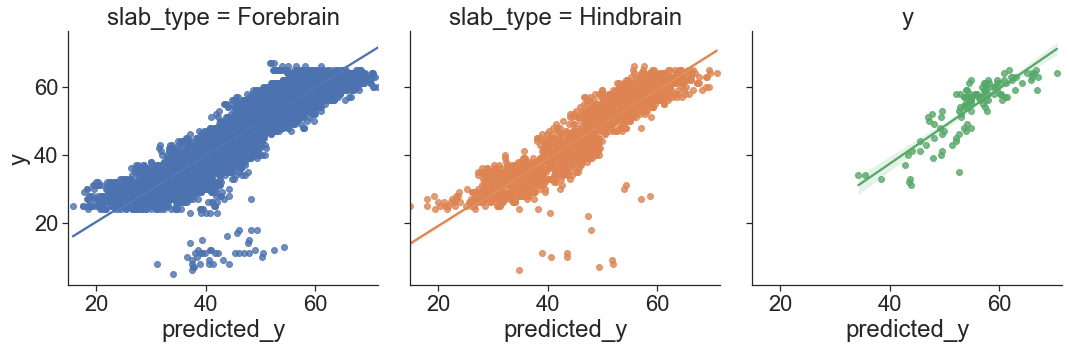

Forebrain r2 =0.828260093081103
Forebrain mae =33.0310713450338
Hindbrain r2 =0.8100330870368647
Hindbrain mae =30.215234847933505
Midbrain r2 =0.7451381810860632
Midbrain mae =35.775988669414055


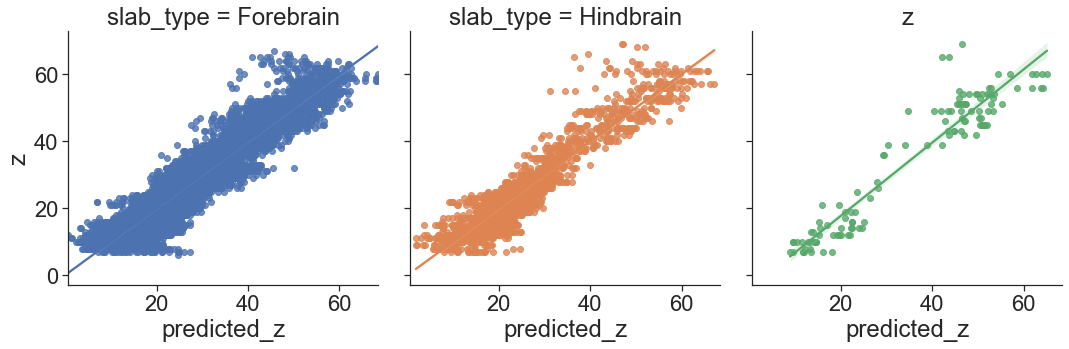

Forebrain r2 =0.873359254454504
Forebrain mae =20.83136486265772
Hindbrain r2 =0.8723358704255965
Hindbrain mae =20.74791641632928
Midbrain r2 =0.9014224135567602
Midbrain mae =19.975248028310347


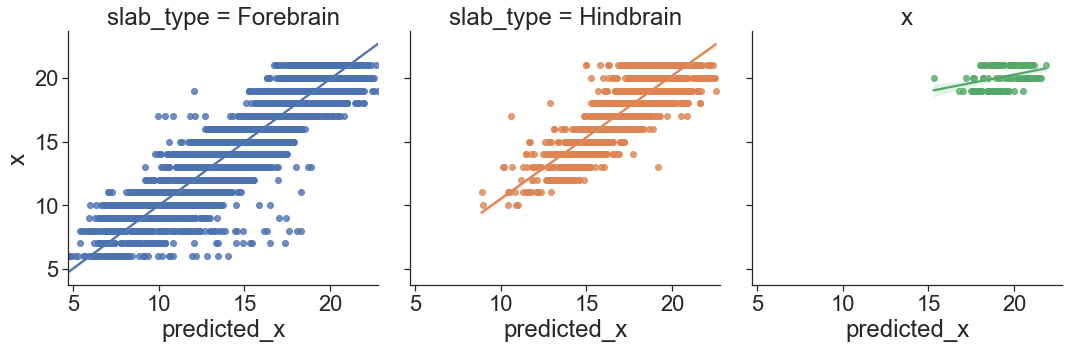

Forebrain r2 =0.8371302347121158
Forebrain mae =14.3279546218442
Hindbrain r2 =0.7290841865005468
Hindbrain mae =12.031818431072981
Midbrain r2 =0.1338162540455987
Midbrain mae =21.348788528210527


In [67]:
pls_mod = PLSRegression(n_components=3)
full_y = coords
pls_mod.fit(pca_tfm, full_y)
# plot model fit
pred = pls_mod.predict(pca_tfm)
for i in range(full_y.shape[-1]):
    plt.close()
    sns.regplot(x=pred[:,i], y=full_y[full_y.columns[i]])
    plt.title(full_y.columns[i])
    plt.show()
    print(stats.pearsonr(pred[:,i], full_y[full_y.columns[i]]))
    print(mean_absolute_error(pred[:,i], full_y[full_y.columns[i]]))
# plot fit by slab type
preds_df = pandas.concat([pandas.DataFrame(pred, index=full_y.index), full_y],axis=1)
preds_df.columns = ['predicted_y', 'predicted_z', 'predicted_x'] + full_y.columns.tolist()
preds_df.loc[:,'slab_type'] = vdf.loc[pca_tfm.index,'BrainPart']
n_components = full_y.shape[-1]
for i in range(n_components):
    plt.close()
    sns.lmplot(x=preds_df.columns[i], y = preds_df.columns[i+n_components], 
               col = 'slab_type', data = preds_df, hue='slab_type')
    plt.title(preds_df.columns[i+n_components])
    plt.show()
    for slab in preds_df.slab_type.unique():
        r2 = stats.pearsonr(preds_df[preds_df.slab_type==slab][preds_df.columns[i]],
                           preds_df[preds_df.slab_type==slab][preds_df.columns[i+n_components]]
                           )[0]**2
        mae = mean_absolute_error(preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i]],
                                  preds_df[preds_df.slab_type==slab
                                          ][preds_df.columns[i+2]])
        print('%s r2 =%s'%(slab,r2))
        print('%s mae =%s'%(slab,mae))

In [72]:
preds_df.loc[:,'inv_z'] = preds_df.z.max() - preds_df.z.values

Text(19.940000000000005, 0.5, 'Z')

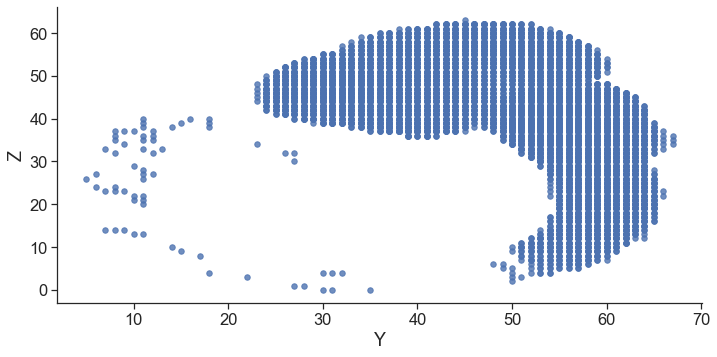

In [73]:
sns.set_context('notebook',font_scale=1.5)
sns.lmplot('y', 'inv_z', #hue = 'slab_type', 
           data=preds_df, fit_reg=False, 
           scatter_kws={"s": 30},aspect=2)
plt.xlabel('Y')
plt.ylabel('Z')
#plt.ylim(-85,90)
#plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ.pdf',
#            bbox_inches='tight')

In [75]:
preds_df.loc[:,'inv_predicted_z'] = preds_df.predicted_z.max() - preds_df.predicted_z.values

Text(24.025701041666665, 0.5, 'Predicted Z')

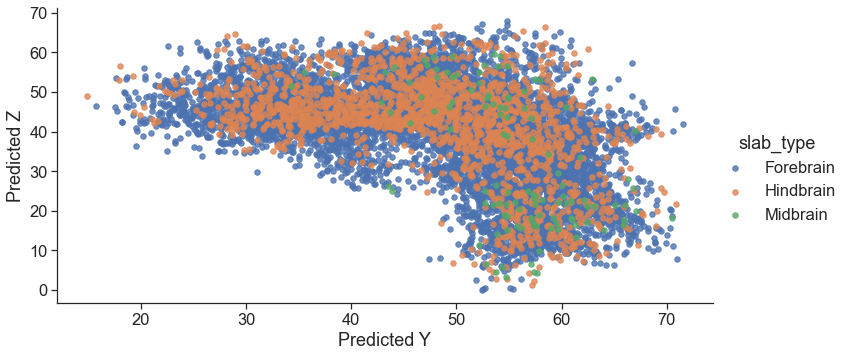

In [77]:
sns.lmplot(x='predicted_y', y='inv_predicted_z', hue = 'slab_type', 
           data=preds_df, aspect=2,
           fit_reg=False, scatter_kws={"s": 30})
plt.xlabel('Predicted Y')
plt.ylabel('Predicted Z')
# plt.ylim(-85,90)
# plt.xlim(-115,75)
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/brain_plot_YZ_pred.pdf',
#            bbox_inches='tight')

In [70]:
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)
bsrx, bsry, allx_bs, ally_bs = xd.bootstrap_features(PLSRegression(n_components=3), 
                                                  pls_mod, 
                                                  pca_tfm, 
                                                  full_y, 
                                                  n_iterations=1000)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


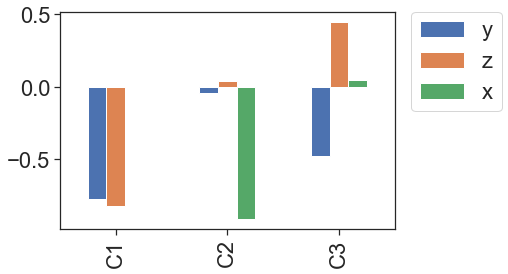

In [78]:
sns.set_context('notebook',font_scale=2)
g = pandas.DataFrame(pls_mod.y_weights_, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
g.set_xticklabels(['C1','C2','C3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

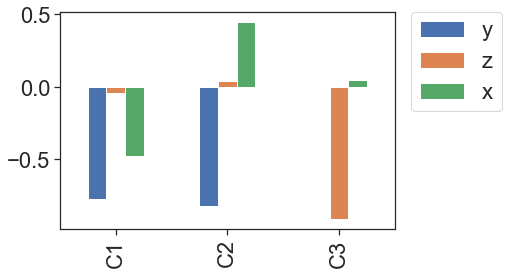

In [79]:
sns.set_context('notebook',font_scale=2)
g = pandas.DataFrame(pls_mod.y_weights_.T, 
                 index=['y','z','x'],
                 columns=['component %s'%x for x in range(3)]).T.plot.bar()
g.set_xticklabels(['C1','C2','C3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [80]:
plotr = pandas.concat([pandas.Series(allx_bs[0].values.flatten()),
                       #pandas.Series(list(range(100))*500)],
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, ''),
 Text(55, 0, ''),
 T

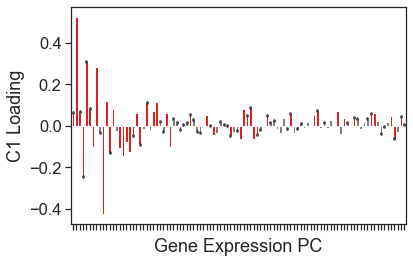

In [81]:
sns.set(font_scale=1.5)
sns.set_style('ticks')
colors = ['Red' if x else 'Grey' for x in multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]]
g=sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C1 Loading')
g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C1_XWeights.pdf',
#             bbox_inches='tight')

In [82]:
sigs = multipletests(bsrx['p'].loc[0], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,0] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc1 = np.dot(pcamod.components_.T, new_loading)
newc1 = pandas.concat([pandas.Series(newc1), pandas.Series(iexp.index)],
                      axis=1)

In [83]:
newc1.loc[:,'acronym'] = gdf.acronym.values

In [84]:
newc1.sort_values(newc1.columns[0])

0     1 acronym
1945 -0.191719  1945     NaN
168  -0.174517   168   Zfhx3
956  -0.167631   956     NaN
474  -0.166989   474    Fgf1
698  -0.123202   698   Hoxd4
...        ...   ...     ...
725   0.129091   725     Id4
1021  0.134973  1021    Pax6
1199  0.137612  1199   Sfrp1
874   0.152709   874    Mest
1005  0.197340  1005    Otx2

[2100 rows x 3 columns]

In [153]:
newc1.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C1_genelist.csv')

Text(0, 0.5, 'C2 Loading')

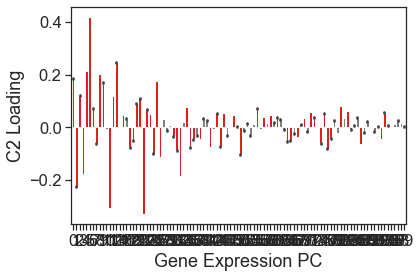

In [85]:
plotr = pandas.concat([pandas.Series(allx_bs[1].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[1]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
#g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_XWeights.pdf',
#             bbox_inches='tight')

In [86]:
sigs = multipletests(bsrx['p'].loc[1], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,1] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc2 = np.dot(pcamod.components_.T, new_loading)
newc2 = pandas.concat([pandas.Series(newc2), pandas.Series(iexp.index)],
                      axis=1)
newc2.loc[:,'acronym'] = gdf.acronym.values

In [87]:
newc2.sort_values(0)

0     1  acronym
1154 -0.151400  1154    Rps12
1229 -0.109913  1229    Slit2
1005 -0.105724  1005     Otx2
697  -0.105392   697    Hoxd3
1261 -0.104992  1261    Sparc
...        ...   ...      ...
666   0.175901   666  Hnrnpab
1248  0.176810  1248    Sox15
474   0.186012   474     Fgf1
700   0.194468   700      NaN
1435  0.197837  1435    Tubb3

[2100 rows x 3 columns]

In [161]:
newc2.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C2_genelist.csv')

Text(0, 0.5, 'C2 Loading')

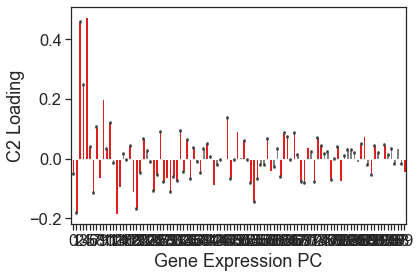

In [89]:
plotr = pandas.concat([pandas.Series(allx_bs[2].values.flatten()),
                       pandas.Series(list(range(100))*1000)],
                      axis=1)
plotr.columns = ['Loading','Component']
colors = ['Red' if x < 0.05 else 'Grey' for x in bsrx['p'].loc[2]]
sns.barplot(x='Component', y='Loading', data=plotr, palette=colors)
plt.xlabel('Gene Expression PC')
plt.ylabel('C2 Loading')
#g.set_xticklabels([None for x in range(100)])
# plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/ManuFigs/C2_XWeights.pdf',
#             bbox_inches='tight')

In [88]:
sigs = multipletests(bsrx['p'].loc[2], method='fdr_bh')[0]
new_loading = [pls_mod.x_loadings_[x,2] if sigs[x] else 0 for x in range(pca_tfm.shape[-1])]
newc3 = np.dot(pcamod.components_.T, new_loading)
newc3 = pandas.concat([pandas.Series(newc3), pandas.Series(iexp.index)],
                      axis=1)
newc3.loc[:,'acronym'] = gdf.acronym.values
newc3.sort_values(0)

0     1 acronym
1005 -0.176183  1005    Otx2
1402 -0.154647  1402  Trim28
1075 -0.151333  1075  Pou3f2
752  -0.149646   752    Irx1
2083 -0.134010  2083   Fzd10
...        ...   ...     ...
1344  0.120268  1344  Tfap2b
1154  0.120443  1154   Rps12
640   0.128636   640   Foxg1
359   0.131496   359    Dlk1
1199  0.253170  1199   Sfrp1

[2100 rows x 3 columns]

In [166]:
newc3.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/GCORR_C3_genelist.csv')

In [90]:
gdf.loc[:,'C1'] = newc1.loc[:,0].values
gdf.loc[:,'C2'] = newc2.loc[:,0].values
gdf.loc[:,'C3'] = newc3.loc[:,0].values

#### Projection

In [172]:
# pcamod = PCA(n_components=100, random_state=123).fit(bigdf)
# sum(pcamod.explained_variance_ratio_)
#pca_tfm = pandas.DataFrame(pcamod.transform(bigdf))
pls_mod = PLSRegression(n_components=3)
#full_y = gdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [71]:
#vdf.loc[:,['y','z','x']] = coords.values

In [103]:
coords.loc[:,'inv_z'] = coords.z.max() - coords.z.values

In [10]:
coords.head()

0     1     2
0  44.0  12.0  23.0
1  45.0  12.0  23.0
2  41.0  13.0  23.0
3  42.0  13.0  23.0
4  43.0  13.0  23.0

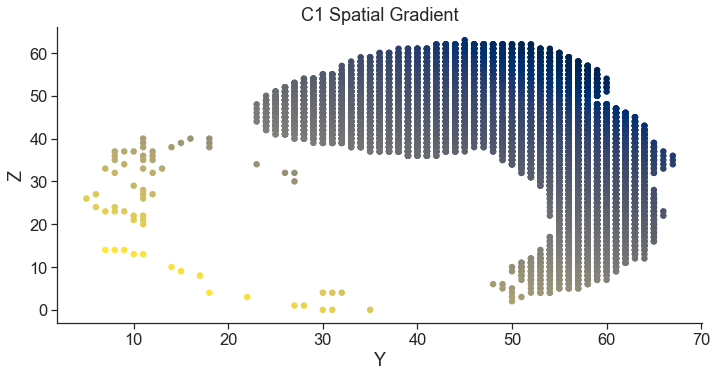

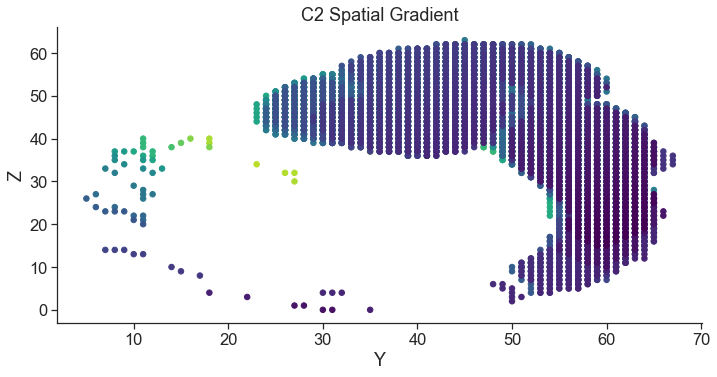

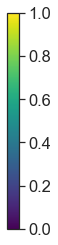

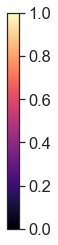

In [112]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

pals = ['cividis','viridis','magma']
for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y[['y','inv_z','x']].values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    coords.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='inv_z',  
                   data=coords, fit_reg=False, aspect=2,
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')

   
    # colorbar
    a = np.array([[0,1]])
    #a = np.linspace(0,1,10)
    plt.figure(figsize=(.2, 5))
    img = plt.imshow(a, cmap=cmap)
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.8, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    #newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
    newticks = [round(norm.inverse(x),2) for x in cbar.get_ticks()]
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(newticks)
#         plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_component_cbar.pdf',
#                    bbox_inches='tight')

    plt.show()




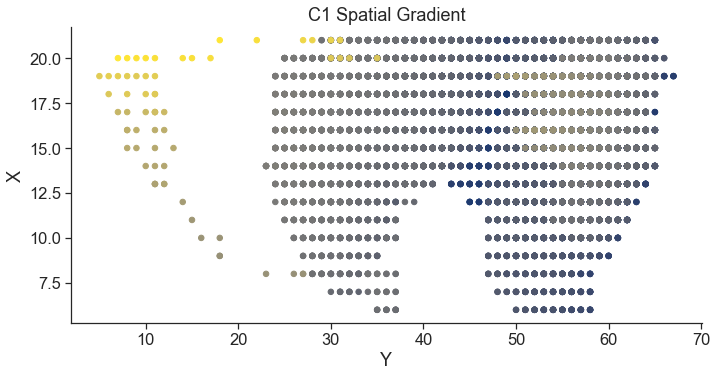

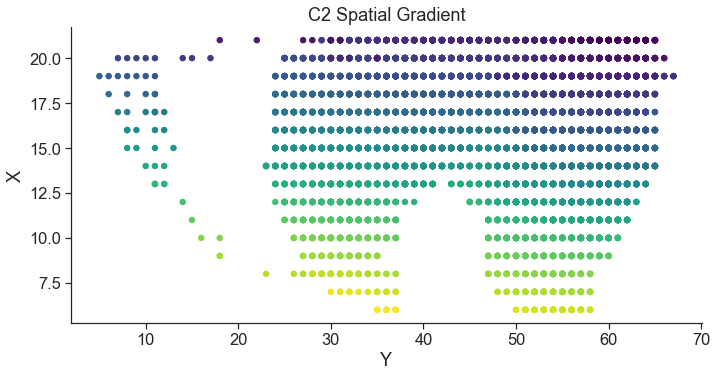

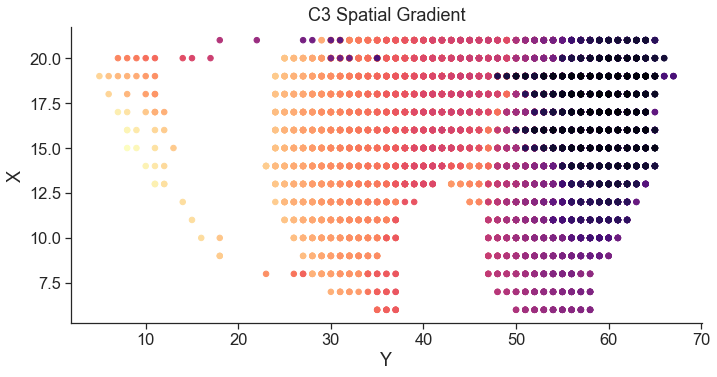

In [117]:
pals = ['cividis','viridis','magma']
for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(full_y[['y','inv_z','x']].values,pls_mod.y_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    vdf.loc[:,'C%s_SmoothGradient'%(i+1)] = sg
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x',  
                   data=coords, fit_reg=False, aspect=2,
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('C%s Spatial Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_SpatialC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')

#     if i == 0:
#     # colorbar
#         a = np.array([[0,1]])
#         #a = np.linspace(0,1,10)
#         plt.figure(figsize=(.2, 5))
#         img = plt.imshow(a, cmap="RdBu_r")
#         plt.gca().set_visible(False)
#         cax = plt.axes([0.1, 0.2, 0.8, 0.6])
#         cbar = plt.colorbar(orientation="vertical", cax=cax)
#         #newticks = [int(round(norm.inverse(x))) for x in cbar.get_ticks()]
#         newticks = [norm.inverse(x) for x in cbar.get_ticks()]
#         cbar.set_ticks(cbar.get_ticks())
#         cbar.set_ticklabels(newticks)
# #         plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_component_cbar.pdf',
# #                    bbox_inches='tight')

#         plt.show()




In [ ]:
pls_mod.x

In [ ]:
971-212-2989

1816 South St
2nd floor

215-686-4420

* lexapro. Drinks a lot on it. unregulated.
* Has mentioned that he is manic, and has suicidal ideations, put himself in harms way


CIT -- 
Someone has to be on site
They don't get involved when someone is aggressive, especially while drunk
Would call 911 if a 302 needs to be 

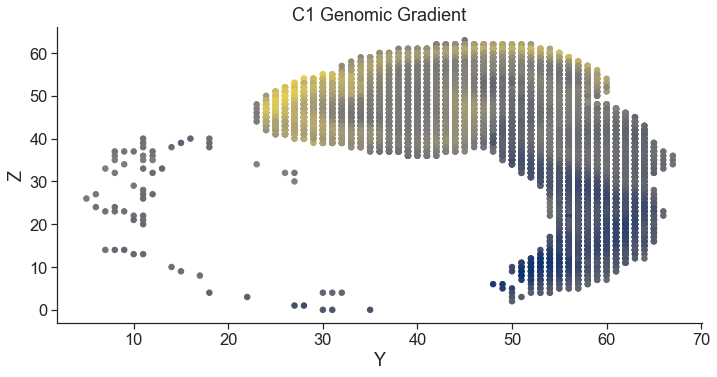

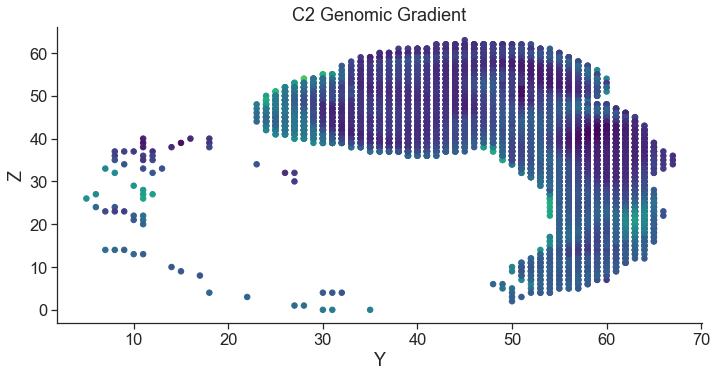

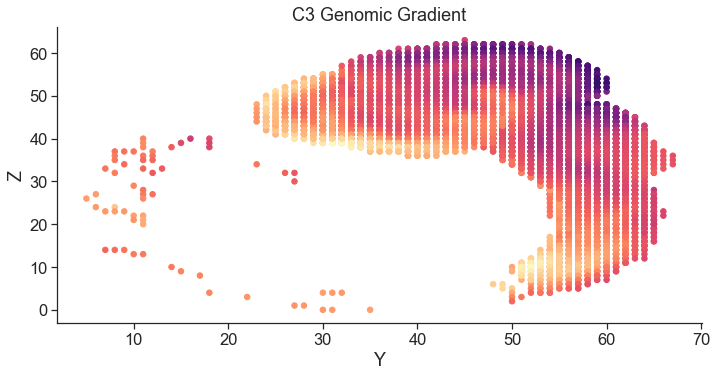

In [120]:
pals = ['cividis','viridis','magma']
for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(pca_tfm.values,pls_mod.x_weights_[:,i])
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='inv_z', aspect=2, 
                   data=coords, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



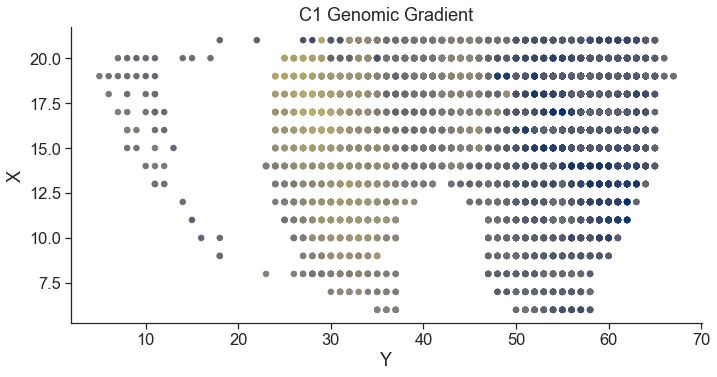

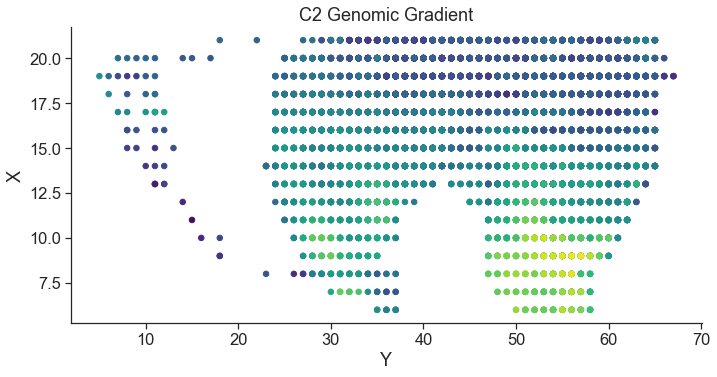

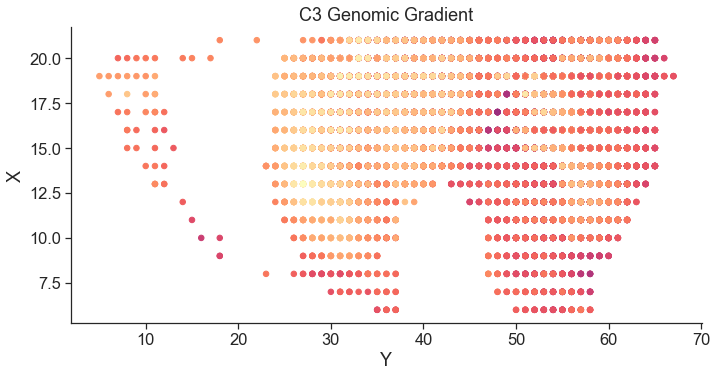

In [121]:
from sklearn.preprocessing import MinMaxScaler

for i in range(pls_mod.y_weights_.shape[0]):
    cmap = sns.color_palette(pals[i],as_cmap=True)
    sg = np.dot(pca_tfm.values,pls_mod.x_weights_[:,i])
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x', aspect=2, 
                   data=coords, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('C%s Genomic Gradient'%(i+1))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



# Homologging

In [192]:
len(gset['EntrezGene ID'].unique())

2038

In [122]:
gset = hlog[(hlog['Common Organism Name']=='mouse, laboratory') &\
            (hlog['EntrezGene ID'].isin(gdf.entrezID.values))]
gset.index = gset['EntrezGene ID'].values
shared = list(set(gdf.entrezID.values) & set(gset.index.values))
gdf.loc[:,'orig_id'] = gdf.index
gdf.index=gdf.entrezID.values


In [123]:
for i,row in gset.iterrows():
    hid = row['HomoloGene ID']
    eid = row['EntrezGene ID']
    match = hlog[(hlog['Common Organism Name']=='human') &\
            (hlog['HomoloGene ID']==hid)]
    if len(match==1):
        gdf.loc[eid,'human_symbol'] = match['Symbol'].values[0]
        gdf.loc[eid,'human_eid'] = match['EntrezGene ID'].values[0]
        gdf.loc[eid,'syns'] = match['Synonyms'].values[0]

In [124]:
human = pandas.read_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/PLS_Component_Expr.csv')
human.head()

gene_symbol                     gene_name   C1_expr   C2_expr   C3_expr
0        A1BG        alpha-1-B glycoprotein  0.001517  0.006065 -0.020001
1    A1BG-AS1                           NaN -0.006685 -0.006733 -0.002762
2         A2M         alpha-2-macroglobulin  0.005135  0.007225  0.002345
3       A2ML1  alpha-2-macroglobulin-like 1 -0.009261 -0.004295 -0.010945
4     A3GALT2                           NaN -0.001305 -0.000388 -0.000463

In [125]:
homogene = [x for x in gdf.human_symbol.values if x in human.gene_symbol.values]
human.loc[:,'orig_index'] = human.index
human.index = human.gene_symbol.values
gdf.index = gdf.human_symbol.values


In [126]:
jnka = gdf.loc[homogene,['C1','C2','C3']]
jnka.columns = ['MouseC1','MouseC2','MouseC3']
jnkb = human.loc[homogene,['C1_expr','C2_expr','C3_expr']]
jnkb.columns = ['HumanC1','HumanC2','HumanC3']
homocomp = pandas.concat([jnka,jnkb],axis=1)
homocomp.head()

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
NRG2    -0.000030  0.000666 -0.000291  0.006455 -0.002230  0.013806
CAMTA1  -0.017842  0.034547 -0.051286  0.006785 -0.009396 -0.003544
DCUN1D4 -0.004326 -0.002869  0.002502  0.001091 -0.000446  0.004482
NFXL1    0.010264  0.001955  0.007767  0.008827  0.009024  0.000342
CPNE7    0.001084 -0.000197 -0.000279 -0.009136  0.004629 -0.007924

In [129]:
sns.set_context('notebook',font_scale=1)
cmat = pandas.DataFrame(np.corrcoef(homocomp.T),
                        index=homocomp.columns,
                        columns=homocomp.columns)
sns.heatmap(cmat,annot=True,center=0,cmap='RdBu_r')

<AxesSubplot:>

In [232]:
homocomp.to_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv')

In [41]:
homocomp = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/MouseHumanComp_Orig.csv',
                           index_col=0)

#### Same thing after redoing human PLS with only mouse genes

In [130]:
hg2 = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/HumanComps_mouseGenes.csv',
                     index_col=0)
hg2.index = hg2.gene_symbol.values
hg2.head()

gene_symbol                                          gene_name  \
NRG2           NRG2                                       neuregulin 2   
CAMTA1       CAMTA1       calmodulin binding transcription activator 1   
DCUN1D4     DCUN1D4  DCN1, defective in cullin neddylation 1, domai...   
NFXL1         NFXL1  nuclear transcription factor, X-box binding-li...   
CPNE7         CPNE7                                         copine VII   

               C1        C2        C3  
NRG2     0.019351 -0.013131  0.037018  
CAMTA1   0.006166 -0.026090 -0.013369  
DCUN1D4 -0.006462 -0.006269  0.015598  
NFXL1    0.021379  0.005243 -0.000481  
CPNE7   -0.035051  0.000959 -0.037282

In [132]:
homocomp

MouseC1   MouseC2   MouseC3   HumanC1   HumanC2   HumanC3
NRG2    -0.000030  0.000666 -0.000291  0.006455 -0.002230  0.013806
CAMTA1  -0.017842  0.034547 -0.051286  0.006785 -0.009396 -0.003544
DCUN1D4 -0.004326 -0.002869  0.002502  0.001091 -0.000446  0.004482
NFXL1    0.010264  0.001955  0.007767  0.008827  0.009024  0.000342
CPNE7    0.001084 -0.000197 -0.000279 -0.009136  0.004629 -0.007924
...           ...       ...       ...       ...       ...       ...
ATP1A2  -0.001025 -0.000989 -0.000051  0.007007  0.001540 -0.001084
KCNB2    0.000327  0.001526 -0.001047 -0.006806  0.002289 -0.005834
FIBCD1   0.001147 -0.000228 -0.000554  0.009074  0.004541 -0.000377
HRH3    -0.000772 -0.000048  0.000147 -0.015595  0.028380  0.026239
TAF13   -0.013987  0.017639 -0.025032 -0.008454 -0.011267  0.002617

[1593 rows x 6 columns]

In [133]:
shared = set(homocomp.index) & set(hg2.index)
for i in range(1,4):
    homocomp.loc[shared,'HumanC%s'%i] = hg2.loc[shared,'C%s'%i].values

In [134]:
sns.set_context('notebook',font_scale=1)
cmat = pandas.DataFrame(np.corrcoef(homocomp.T),
                        index=homocomp.columns,
                        columns=homocomp.columns)
sns.heatmap(cmat,annot=True,center=0,cmap='RdBu_r')

<AxesSubplot:>

r = -0.229, p = 0.0


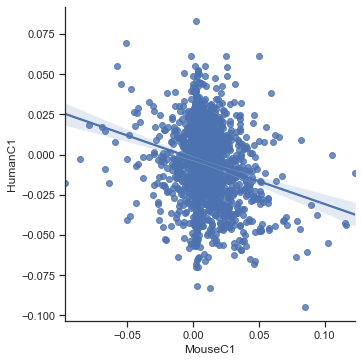

r = -0.173, p = 0.0


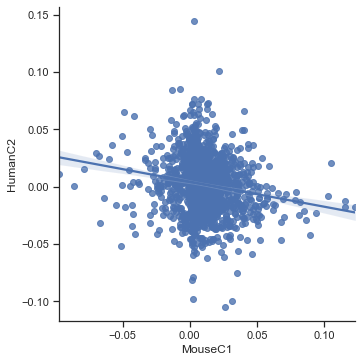

r = -0.072, p = 0.004


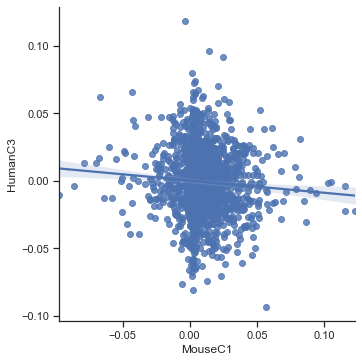

r = 0.096, p = 0.0


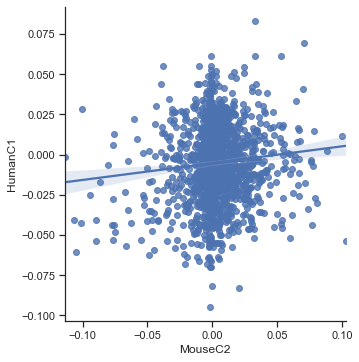

r = -0.095, p = 0.0


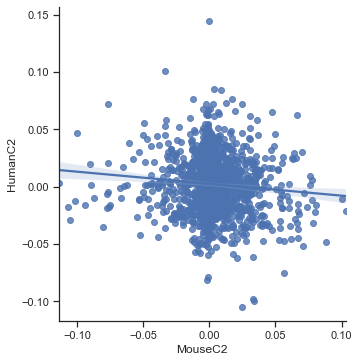

r = 0.097, p = 0.0


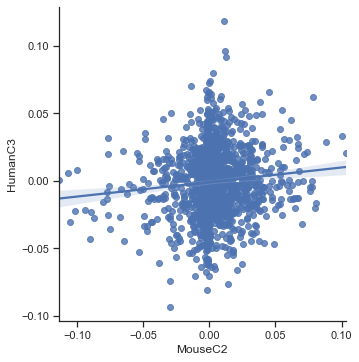

r = 0.166, p = 0.0


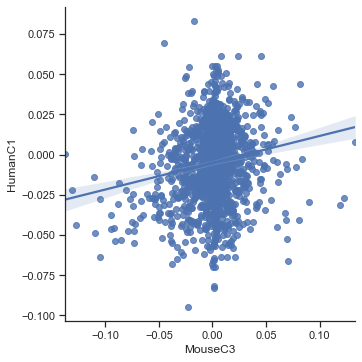

r = 0.079, p = 0.002


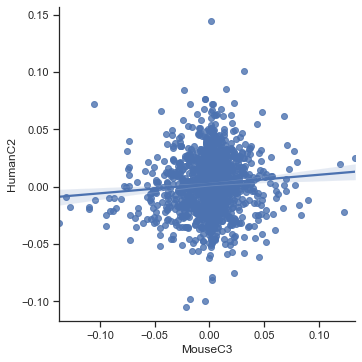

r = 0.006, p = 0.804


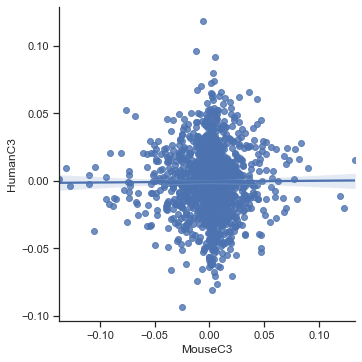

In [240]:
for i in range(1,4):
    for j in range(1,4):
        sns.lmplot(x='MouseC%s'%i,y='HumanC%s'%j,data=homocomp)
        r,p = stats.pearsonr(homocomp['MouseC%s'%i],
                            homocomp['HumanC%s'%j])
        print('r = %s, p = %s'%(round(r,3),round(p,3)))
        plt.show()

#### Mouse expression of human components

In [135]:
iexp.shape

(2100, 10834)

In [136]:
hexp = pandas.DataFrame(iexp,copy=True)
hexp.index = gdf.index
hexp = hexp.loc[homocomp.index]
hexp.shape

(1593, 10834)

In [248]:
np.dot(homocomp.HumanC1.values,hexp).shape

(24044,)

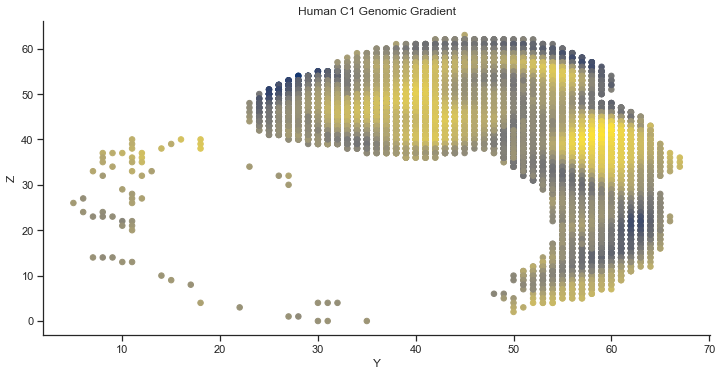

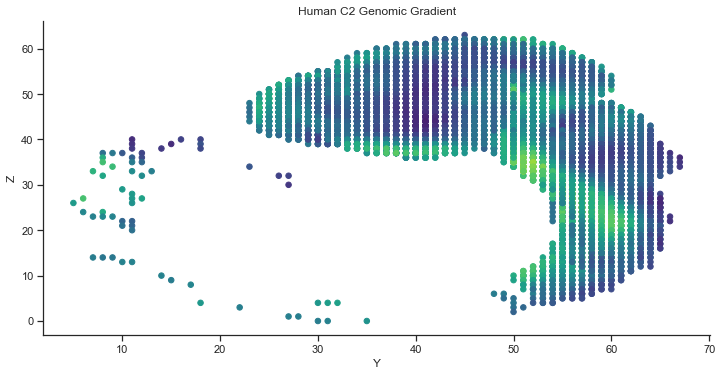

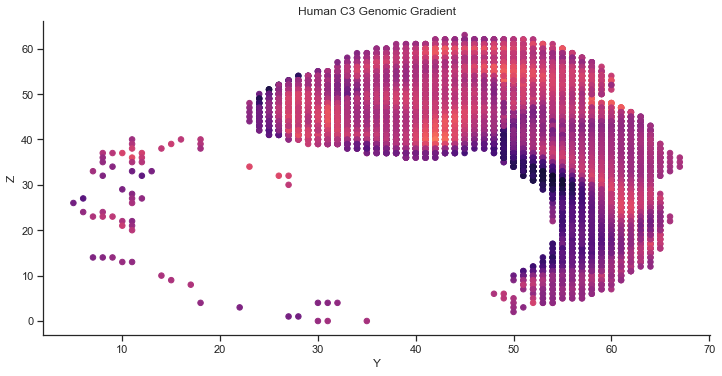

In [142]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize


for i in range(1,4):
    cmap = sns.color_palette(pals[(i-1)],as_cmap=True)
    #if i == 2:
    sg = np.dot(homocomp['HumanC%s'%i].values,hexp)
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='inv_z', aspect=2, 
                   data=coords, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Human C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



In [39]:
coords.shape

(24044, 3)

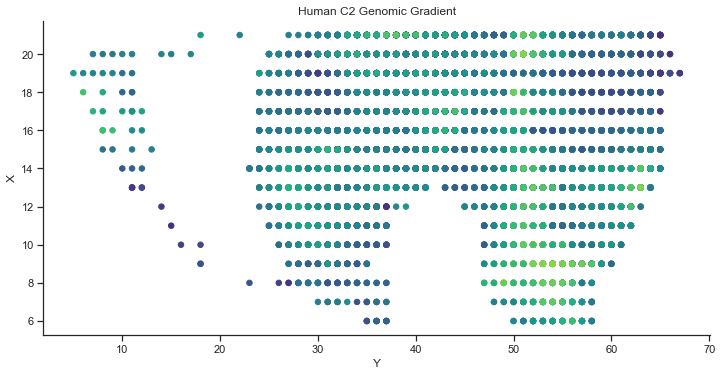

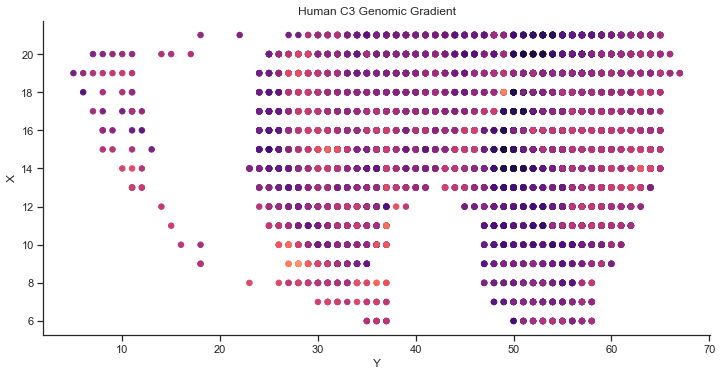

In [143]:
from sklearn.preprocessing import MinMaxScaler

for i in range(1,4):
    cmap = sns.color_palette(pals[(i-1)],as_cmap=True)
    #if i == 2:
    sg = np.dot(homocomp['HumanC%s'%i].values,hexp)
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='y', y='x', aspect=2, 
                   data=coords, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('X')
    plt.title('Human C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.ylim(-85,90)
#     plt.xlim(-115,75)
#     plt.xticks([-100,-50,0,50])
#     plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



In [255]:
hexp.to_csv('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/PLS_GXP_CollabSpace/Mouse_GXp_matrix.csv')

#### Spatial comparison

In [144]:
spatial_exp = pandas.DataFrame(columns=homocomp.columns)
for col in homocomp.columns:
    spatial_exp.loc[:,col] = np.dot(homocomp[col].values,hexp)

<AxesSubplot:>

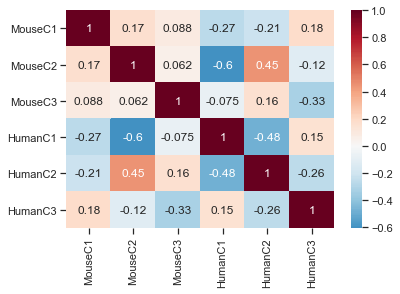

In [145]:
sns.set_context('notebook',font_scale=1)
sns.heatmap(pandas.DataFrame(np.corrcoef(spatial_exp.T),
                            index=homocomp.columns,columns=homocomp.columns),
            center=0,annot=True,cmap='RdBu_r')

# Human Exp

In [160]:
hgdf = pandas.read_csv('/Users/jacobv/git/PLS_GXp/data/PLS_GXp_gdf.csv')
hbigdf = pandas.read_csv('/Users/jacobv/Science/PLS_GXP/Mouse/Human_bigdf_mousgenes.csv',
                       index_col=0)

In [163]:
shared = set(hbigdf.columns) & set(homocomp['MouseC%s'%i].index)

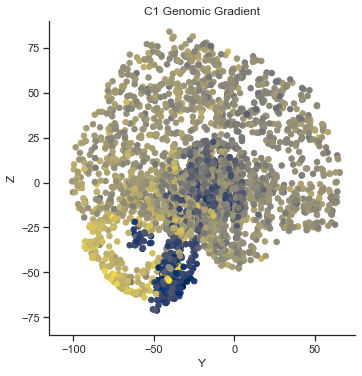

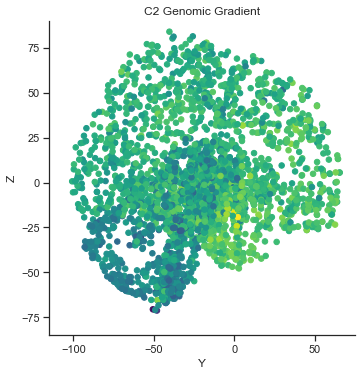

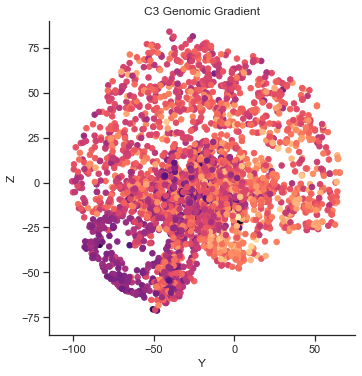

In [176]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import Normalize

for i in range(1,4):
    cmap = sns.color_palette(pals[(i-1)],as_cmap=True)
    #if i == 2:
    shared = set(hbigdf.columns) & set(homocomp['MouseC%s'%i].index)
    sg = np.dot(homocomp.loc[shared,'MouseC%s'%i],hbigdf.T.loc[shared])
    hgdf.loc[:,'MouseC%s'%i] = sg
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_y', y='mni_nlin_z',  
                   data=hgdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



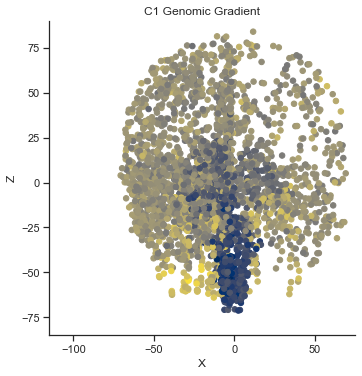

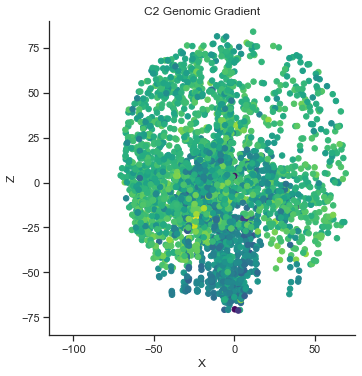

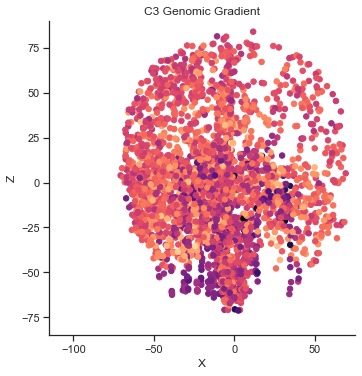

In [167]:
for i in range(1,4):
    cmap = sns.color_palette(pals[(i-1)],as_cmap=True)
    #if i == 2:
    shared = set(hbigdf.columns) & set(homocomp['MouseC%s'%i].index)
    sg = np.dot(homocomp.loc[shared,'MouseC%s'%i],hbigdf.T.loc[shared])
    #else:
    #    sg = -gdf.loc[:,'Component%s_Expresion'%(i+1)].values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))

    g = sns.lmplot(x='mni_nlin_x', y='mni_nlin_z',  
                   data=hgdf, fit_reg=False, 
                   scatter_kws={"s": 30,'color':cscale},
                  palette='RdBu_r')
    
    plt.xlabel('X')
    plt.ylabel('Z')
    plt.title('C%s Genomic Gradient'%(i))
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(-85,90)
    plt.xlim(-115,75)
    plt.xticks([-100,-50,0,50])
    plt.yticks(list(range(-75,76,25)))
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/brain_plot_GenomicC%s_YZ.pdf'%(i+1),
#                bbox_inches='tight')



# dev trajectory

In [237]:
hgdf.columns[-3:]
g2=pandas.read_csv('/Users/jacobv/Science/PLS_GXP/txfer/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2 = g2.loc[hgdf[hgdf.columns[0]].values]
hgdf.loc[:,'brain_divison'] = g2.brain_divison.values

In [183]:
c_vals

MouseC3       sem
brain_divison                          
Anterior_Cingulate   2.865584  0.020423
Cerebellum           2.266029  0.008679
DCN                  2.492209  0.038192
Forebrain            2.660043  0.037406
Frontal              2.733513  0.009130
Hypothalamus         2.535138  0.023657
Insula               2.492591  0.039349
Limbic               2.482423  0.020580
Medulla              2.568911  0.016333
Occipital            2.620656  0.013542
Other_Dien           2.226076  0.052934
Parietal             2.677206  0.012282
Pons                 2.482135  0.020330
Posterior_Cingulate  2.709064  0.022825
Sensorimotor         2.649737  0.011112
Striatum             2.807587  0.014630
Tectum               2.656442  0.071478
Tegmentum            2.427761  0.025785
Temporal             2.757786  0.007274
Thalamus             2.484556  0.020337

In [238]:
jnk = []
for i in range(1,4):
    c_vals = pandas.pivot_table(hgdf,values='MouseC%s'%i,
                                 index='brain_divison',aggfunc=np.mean
                                )
    for div in c_vals.index:
        sem = hgdf[hgdf.brain_divison==div]['MouseC%s'%i
                                         ].sem()
        c_vals.loc[div,'C%ssem'%i] = sem
    jnk.append(c_vals)
c_vals = pandas.concat(jnk,axis=1)
#c_vals.to_csv('~/Science/PLS_GXP/txfer/ManuFigs/GCorr_BSComp_MOUSE_C%s_data.csv'%i)


In [239]:
bsdf = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_expression_original.csv',
                     )
rmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/gene_metadata_original.csv')
cmd = pandas.read_csv('/Users/jacobv/Science/Brainspan/ForBslav/samples_metadata.csv')
dups = []
dind = []
catch = []
for i,row in rmd.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)
bad_index = rmd[rmd.gene_symbol.isin(dups)].index
rmd.drop(bad_index,inplace=True)
bsdf.drop(bad_index,inplace=True)
bsdf.index = bsdf.gene_symbol.values
bsdf.drop('gene_symbol',axis=1,inplace=True)

In [240]:
bsgdf = pandas.read_csv('data/GCorr_Brainspan.csv')
# deal with the nine months before birth before logging...
for i,row in bsgdf.iterrows():
    age = row['age']
    num,measure = age.split(' ')
    if measure == 'pcw':
        fage = int(num) / 4.35
    elif measure == 'yrs':
        fage = int(num) * 12
    else:
        fage = int(num)
    bsgdf.loc[i,'age_in_months'] = fage
bsgdf.loc[:,'log_age_months'] = np.log(bsgdf['age_in_months']).values


In [274]:
Occipital =  ['Ocx','V1C']
Somatomotor=['M1C-S1C','M1C','S1C']
Limbic=['AMY','HIP']
GangEm= ['MGE','CGE','LGE']
Temporal=['STC','ITC','TCx','A1C']
Cerebellum=['URL','CB','CBC']
Subcortex=['DTH','STR','MD']
Frontal=['MFC','DFC','OFC','VFC']
Parietal=['PCx','IPC']

Striatum = ['STR']
Thalamus = ['MD','DTH']
             
divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Subcortex,Frontal,Parietal]
names = ['Occipital','Somatomotor','Limbic','GangEm','Temporal','Cerebellum','Subcortex','Frontal','Parietal']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    bsgdf.loc[bsgdf[bsgdf.structure_acronym.isin(div)].index,'MacroStructure'] = name

divs = [Occipital,Somatomotor,Limbic,GangEm,Temporal,Cerebellum,Frontal,Parietal,Striatum,Thalamus]
names = ['Occipital','Sensorimotor','Limbic','GangEm','Temporal','Cerebellum','Frontal','Parietal','Striatum','Thalamus']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    bsgdf.loc[bsgdf[bsgdf.structure_acronym.isin(div)].index,'MacroStructure2'] = name

fetal = ['8 pcw', '9 pcw', '12 pcw', '13 pcw', '16 pcw', 
         '17 pcw', '19 pcw', '21 pcw','24 pcw', '25 pcw', 
         '26 pcw', '35 pcw', '37 pcw',]
infant = ['4 mos','10 mos','1 yrs',]
child = ['2 yrs', '3 yrs','4 yrs','8 yrs','11 yrs']
adolescent = ['11 yrs', '13 yrs', '15 yrs', '18 yrs', '19 yrs',]
adult = ['21 yrs', '23 yrs','30 yrs', '36 yrs', '37 yrs',
        '40 yrs']
divs = [fetal,infant,child,adolescent,adult]
names = ['fetal','infant','child','adolescent','adult']
bdivs = dict(zip(names,divs))
for name, div in bdivs.items():
    bsgdf.loc[bsgdf[bsgdf.age.isin(div)].index,'Age_Stage'] = name

In [263]:
shared = set(homocomp.index.values) & set(bsdf.index.values)
bshomo = pandas.DataFrame(homocomp.loc[shared],copy=True)
for i in range(1,4):
    bsgdf.loc[:,'MouseC%s'%i] = np.dot(bshomo['MouseC%s'%i].values,bsdf.loc[shared])

In [262]:
sharecols = set(c_vals.index) & set(bsgdf.MacroStructure2.unique())

In [212]:
def external_validation_plot(i,c_vals,gdf,sharecols,labels,outfile,show=True,save=True):
    aba = c_vals[['MouseC%s'%i,'C%ssem'%i]]
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(bsgdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='MouseC%s'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = bsgdf[bsgdf.MacroStructure2==div]['MouseC%s'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = sharecols
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
          )
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'BS_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    if show:
        plt.show()
    if save:
        plt.savefig(outfile,bbox_inches='tight')

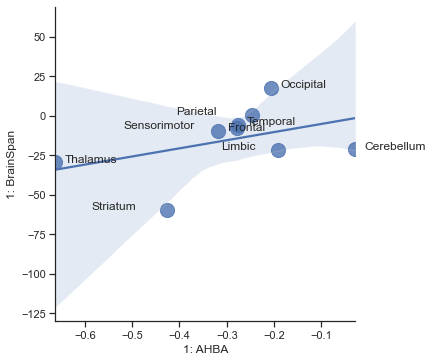

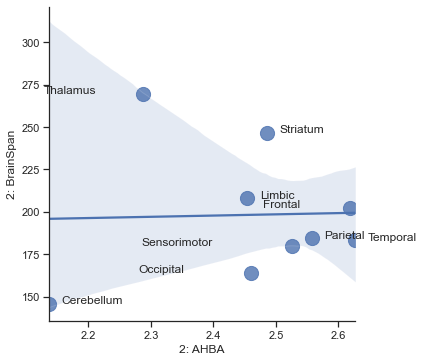

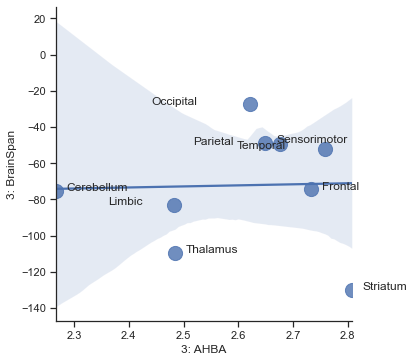

In [264]:
for i in range(1,4):
    aba = c_vals[['MouseC%s'%i,'C%ssem'%i]]
    aba.columns = ['ABA_mean','ABA_sem']
    bs = pandas.pivot_table(bsgdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='MouseC%s'%i,
                             index='MacroStructure2',aggfunc=np.mean
                            )
    for div in bs.index:
        sem = bsgdf[bsgdf.MacroStructure2==div]['MouseC%s'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['BS_mean','BS_sem']
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = sharecols
    
    sns.lmplot(x='ABA_mean',y='BS_mean',data=comp,
           scatter_kws={'marker':'o','s':200}
           #hue='region',legend=False,fit_reg=False
          )
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        #xsem = c2_comp.loc[div,'ABA_sem']
        y = comp.loc[div,'BS_mean']
        #ysem = c2_comp.loc[div,'BS_sem']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x+.02, y,div,{'size':12})
        else:
            plt.text(x-dist, y,div,{'size':12},
                     )
    #     plt.plot([x-xsem,x+xsem],[y,y],c='k')
    #     plt.plot([x,x],[y-ysem,y+ysem],c='k')
    plt.xlabel('%s: AHBA'%i)
    plt.ylabel('%s: BrainSpan'%i)
    plt.show()

In [266]:
gpdfs = {}
for i in range(1,4):
    gpdf = bsgdf[['donor_id','MouseC%s'%i,'MacroStructure2']
                  ].set_index(['donor_id'],append=True
                             ).pivot_table(index='donor_id',
                                           columns='MacroStructure2',
                                           values='MouseC%s'%i)
    gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})

In [267]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = c_vals[['MouseC%s'%c,'C%ssem'%c]]
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-3]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 5:
            forcorr.loc[:,'gvec'] = row.values[:-3]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [276]:
cols = ['column_num', 'donor_id', 'donor_name', 'age', 
        'gender','structure_id', 'structure_acronym', 'structure_name',
       'Age_Stage', 'Age_Epoch', 'Age_Period',
       'MacroStructure', 'MacroStructure2', 'NT_Segment', 'Sensorifugal',
       'age_in_months','log_age_months']
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = bsgdf.groupby('donor_id')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

In [281]:
def trajectory_plot(c,subsum,bsgdf,outfile,save=True,show=True):
    g=sns.lmplot(x='log_age_months',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'log_age_months']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.log_age_months.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    g.set_xticklabels(rotation=90)
    g.set_xticklabels(rotation=90)
    for stage in bsgdf.Age_Stage.unique():
        levels = bsgdf[bsgdf.Age_Stage==stage]['log_age_months'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('C%s AHBA Similarity'%c,fontsize=30)
    plt.xlabel('Donors',fontsize=30)
    plt.xticks([])
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
    plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
             transform=g.ax.transAxes)
    plt.axhline(0,ls='--',c='k')
    if save:
        plt.savefig(outfile,bbox_inches='tight')
    if show:
        plt.show()

r=0.489, p=0.0025


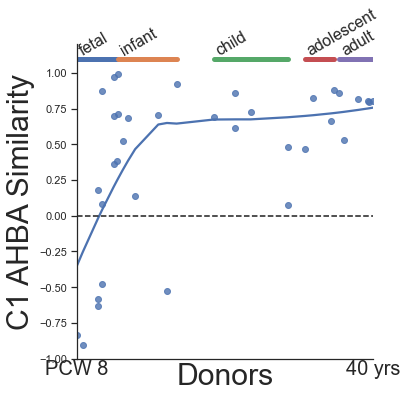

r=0.42, p=0.0108


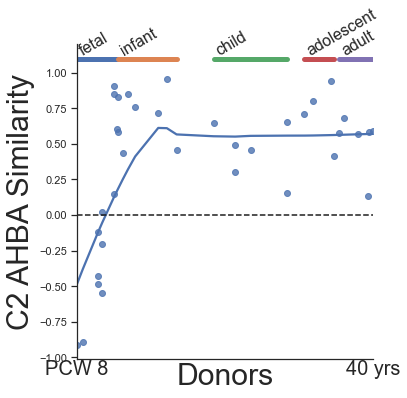

r=-0.02, p=0.9088


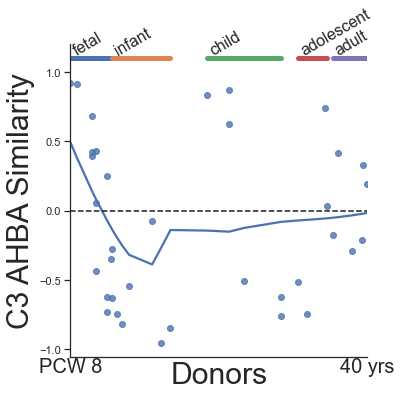

In [280]:
for c in range(1,4):
    g=sns.lmplot(x='log_age_months',y='C%s_r'%c,
                #hue='SEX',
                lowess=True,
               data=subsum)
    plotr = pandas.DataFrame(subsum[['C%s_r'%c,'log_age_months']],
                            copy=True).dropna()
    r,p=stats.pearsonr(plotr['C%s_r'%c].values,
                      plotr.log_age_months.values)
    print('r=%s, p=%s'%(round(r,3),round(p,4)))
    g.set_xticklabels(rotation=90)
    g.set_xticklabels(rotation=90)
    for stage in bsgdf.Age_Stage.unique():
        levels = bsgdf[bsgdf.Age_Stage==stage]['log_age_months'].values
        xmin = np.min(levels)
        xmax = np.max(levels)
        plt.plot([xmin,xmax],[1.1,1.1],lw=5)
        #loc = xmin + (xmax-xmin)*.5
        plt.text(xmin,1.1,stage,fontsize=16,ha='left',
                 va='bottom',rotation=30)
    plt.ylabel('C%s AHBA Similarity'%c,fontsize=30)
    # plt.yticks([])
    plt.xlabel('Donors',fontsize=30)
    plt.xticks([])
    ymin = subsum['C%s_r'%c].min() - 0.1
    plt.text(0,-0.05,'PCW 8',fontsize=20,ha='center',
         transform=g.ax.transAxes)
    plt.text(1,-0.05,'40 yrs',fontsize=20,ha='center',
             transform=g.ax.transAxes)
    plt.axhline(0,ls='--',c='k')
#     plt.savefig('/Users/jacobv/Science/PLS_GXP/txfer/ManuFigs/BrSp_CompR_C%s.pdf'%c,
#                bbox_inches='tight')
    plt.show()